# 평균 이동(Mean Shift)

* 중심을 군집의 중심(데이터가 모여 있는 밀도가 가장 높은 곳)으로 지속적으로 움직이면서 군집화 수행.
* 군집 중심도 = 데이터 포인트가 모여있는 곳 => 확률 밀도 함수(probability density function)를 이용
* 가장 집중적으로 데이터가 모여있어 확률 밀도 함수가 피크인 지점을 군집으로 선명 -> 확률 밀도 함수를 찾기 위해서 KDE(Kernel Density Estimation)를 이용

### 과정
1. 특정 데이터를 반경 내의 데이터 분포 확률 밀도가 가장 높은 곳으로 이동하기 위해 주변 데이터와의 거리 값을 KDE 함수 값으로 입력.
2. 그 반환값으로 현재 위치에서 업데이트 하면서 이동.
3. 위 과정을 반복하면서 데이터 군집 중심점을 찾아냄.

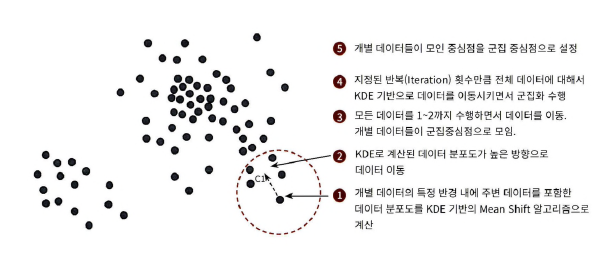


### KDE(Kernel Density Estimation)

* 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 방식
* 관측된 데이터 각각에 함수를 적용한 값을 모둔 더한 뒤 데이터 건수로 나눠 확률 밀도 함수를 추정.
* 확률 밀도 함수 PDF(Probability Density Function)는 확률 변수의 분포를 나타내는 함수. ex) 감마, 정규, t-분포 등
* 대표적인 커널 함수로 가우시안 분포 함수 사용

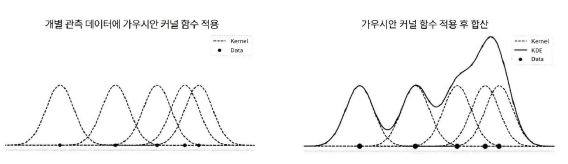

#### KDE 함수식

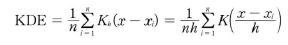

* K는 커널 함수 / x는 확률 변숫값 / xi는 관측값 / h는 대역폭(bandwidth)
* 대역폭 h : KDE 형태를 부드러운(또는 뾰족한) 형태로 평활화(Smoothing)하는 데 적용. 이 h를 어떻게 설정하느냐에 따라 확률 밀도 성능을 크게 좌우할 수 있다.

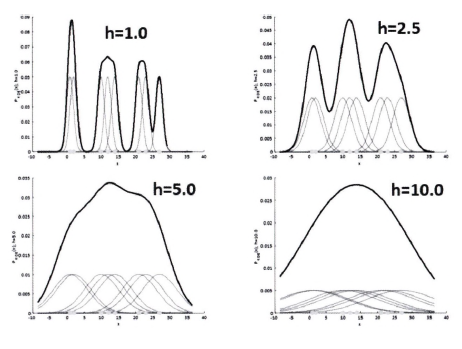

* h = 작은 h값(h=1.0)은 좁고 뾰족한 KDE. 이는 변동성이 큰 방식으로 확률 밀도 함수를 추정 -> 과적합하기 쉬움.
* h = 큰 h값(10)은 과도하게 평활화(smoothing)된 KDE로 인해 지나치게 단순화된 방식으로 확률 밀도 함수를 추정 -> 과소적합하기 쉬움.

=> 적절한 KDE의 대역폭 h를 계산하는 것이 KDE 기반의 평균 이동 군집화에서 매우 중요.
    
* 대역폭 h가 클수록 평활화된 KDE로 인해 적은 수의 군집 중심점을 가짐.
* 대역폭 h가 적을수록 많은 수의 군집 중심점을 가짐.
* 평균 이동 군집화는 군집의 개수를 지정하지 않는다. 오직 대역폭의 크기에 따라 군집화를 수행.
* 사이킷런의 평균 이동 군집화 -> MeanShift 클래스

### MeanShift 클래스 파라미터
* 중요 파라미터 bandwidth : KDE의 대역폭 h와 동일
* 최적 대역폭 계산을 위한 사이킷런의 estimate_bandwidth() 함수 제공.



In [1]:
# make_blobs()의 cluster_std=0.7로 정한 3개의 군집 데이터에 대해 bandwidth를 0.8로 설정한 평균 이동 군집화 알고리즘 적용
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형 :',np.unique(cluster_labels))

cluster labels 유형 : [0 1 2 3 4 5]


군집이 0부터 5까지 6개로 분류 -> 지나치게 세분화되어 군집화.

bandwidth값을 작게 할수록 군집 개수가 많아진다.

In [2]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형 :',np.unique(cluster_labels))

cluster labels 유형 : [0 1 2]


In [3]:
# estimate_bandwidth()의 파라미터로 피처 데이터 세트를 입력 -> 최적 bandwidth 값을 반환해줌
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X)
print('bandwidth 값:',round(bandwidth, 3))

bandwidth 값: 1.816


In [4]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
clusterDF.head(3)

,ftr1,ftr2,target
0,-1.671737,3.534007,2
1,0.732732,4.413232,0
2,1.084733,4.568501,0


In [5]:
# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형 :',np.unique(cluster_labels))

cluster labels 유형 : [0 1 2]


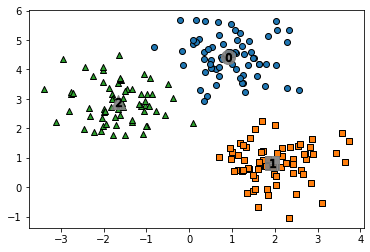

In [6]:
# 시각화
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]

    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별로 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
plt.show()

In [7]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: meanshift_label, dtype: int64


### 평균 이동 장점
* 데이터 세트의 형태를 특정 형태로 가정, 특정 분포도 기반의 모델로 가정하지 않아 유연한 군집화 가능
* 이상치 영향력이 크지 않음
* 미리 군집 개수를 지정하지 않음

### 평균 이동 단점
* 알고리즘 수행 시간이 오래 걸림
* bandwidth의 크기에 따른 군집화 영향도가 매우 큼

### 결론
* 평균 이동 군집화 기법은 분석 업무 기반의 데이터 세트보다는 컴퓨터 비전 영역에서 더 많이 사용된다.
* 이미지나 영상 데이터에서 특정 개체를 구분하거나 움직임을 추적하는 데 뛰어난 역할을 수행하는 알고리즘.